# Import libraries

In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

2025-10-20 23:22:03.264615: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-20 23:22:03.309792: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-20 23:22:04.262594: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Data Preperation

In [2]:
train = tf.keras.utils.image_dataset_from_directory(
    "train",
    image_size=(128, 128),
    batch_size=32,
    shuffle=True
)

val = tf.keras.utils.image_dataset_from_directory(
    "val",
    image_size=(128, 128),
    batch_size=32,
    shuffle=False
)

test = tf.keras.utils.image_dataset_from_directory(
    "test",
    image_size=(128, 128),
    batch_size=32,
    shuffle=False,
    label_mode=None
)

Found 20000 files belonging to 2 classes.


I0000 00:00:1760973725.706136     884 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 5000 files belonging to 2 classes.
Found 500 files.


In [3]:
# Normalization layer (0–255 -> 0–1)
normalizer = layers.Rescaling(1./255)

# Image augmentation on train
data_augment = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomTranslation(0.1, 0.1),
])

# Make pipelined datasets
train_ds = (train
            .map(lambda x,y: (normalizer(data_augment(x)), y), num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE))

val_ds   = (val
            .map(lambda x,y: (normalizer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE))

test_ds  = (test
            .map(lambda x: normalizer(x), num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE))

print("Classes:", train.class_names)
print("Classes:", val.class_names)

Classes: ['cat', 'dog']
Classes: ['cat', 'dog']


# Build CNN model

In [4]:
def build_cnn(input_shape=(128,128,3)):
    return models.Sequential([
        layers.Input(shape=input_shape),

        # Block 1
        layers.Conv2D(32, (3,3), padding="same", activation="relu"),
        layers.Conv2D(32, (3,3), padding="same", activation="relu"),
        layers.MaxPooling2D(),

        # Block 2
        layers.Conv2D(64, (3,3), padding="same", activation="relu"),
        layers.Conv2D(64, (3,3), padding="same", activation="relu"),
        layers.MaxPooling2D(),

        # Block 3
        layers.Conv2D(128, (3,3), padding="same", activation="relu"),
        layers.Conv2D(128, (3,3), padding="same", activation="relu"),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dropout(0.4),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid")  # binary
    ])

model = build_cnn((128,128,3)) 
model.compile( 
    optimizer=tf.keras.optimizers.Adam(1e-3), 
    loss="binary_crossentropy", 
    metrics=["accuracy", tf.keras.metrics.AUC(name="AUC")] 
) 
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,481,569 (17.10 MB)

 Trainable params: 4,481,569 (17.10 MB)

 Non-trainable params: 0 (0.00 B)

# Callbacks

In [5]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "cnn_catdog.keras", monitor="val_accuracy", save_best_only=True
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=3, restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

# Fit Model

In [6]:
print("TF version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))   # 有 GPU 会列出来

# 更直观：让 TF 打印每个 op 被放到什么设备上
tf.debugging.set_log_device_placement(True)

TF version: 2.20.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30


2025-10-20 23:22:09.246332: I external/local_xla/xla/service/service.cc:163] XLA service 0x781b90021e80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-20 23:22:09.246397: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-10-20 23:22:09.325915: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-20 23:22:09.740690: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400
2025-10-20 23:22:09.895894: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-20 23:22:10.

  4/625 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - AUC: 0.4518 - accuracy: 0.3555 - loss: 0.7547

I0000 00:00:1760973737.249179     977 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 40ms/step - AUC: 0.5444 - accuracy: 0.5292 - loss: 0.6901 - val_AUC: 0.6073 - val_accuracy: 0.5622 - val_loss: 0.6826 - learning_rate: 0.0010
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - AUC: 0.6257 - accuracy: 0.5900 - loss: 0.6685 - val_AUC: 0.7045 - val_accuracy: 0.6302 - val_loss: 0.6412 - learning_rate: 0.0010
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - AUC: 0.7272 - accuracy: 0.6662 - loss: 0.6141 - val_AUC: 0.7892 - val_accuracy: 0.6810 - val_loss: 0.5904 - learning_rate: 0.0010
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - AUC: 0.7824 - accuracy: 0.7127 - loss: 0.5642 - val_AUC: 0.8271 - val_accuracy: 0.7276 - val_loss: 0.5356 - learning_rate: 0.0010
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - AUC: 0.8166 - accuracy: 0.7416 - loss: 0.5262 - val_AUC: 0.8472 - val_accuracy: 0.7650 - val_loss: 0.4889 - learning_rate: 0.0010
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - AUC: 0.8373 - accuracy: 0

In [8]:
model.save("cnn_catdog.keras")

# Evaluate

In [9]:
val_loss, val_acc, val_auc = model.evaluate(val_ds, verbose=0)
print(f"Validation — loss: {val_loss:.4f}, acc: {val_acc:.4f}, AUC: {val_auc:.4f}")
model.summary()

Validation — loss: 0.2997, acc: 0.8824, AUC: 0.9571


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,444,709 (51.29 MB)

 Trainable params: 4,481,569 (17.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,963,140 (34.19 MB)

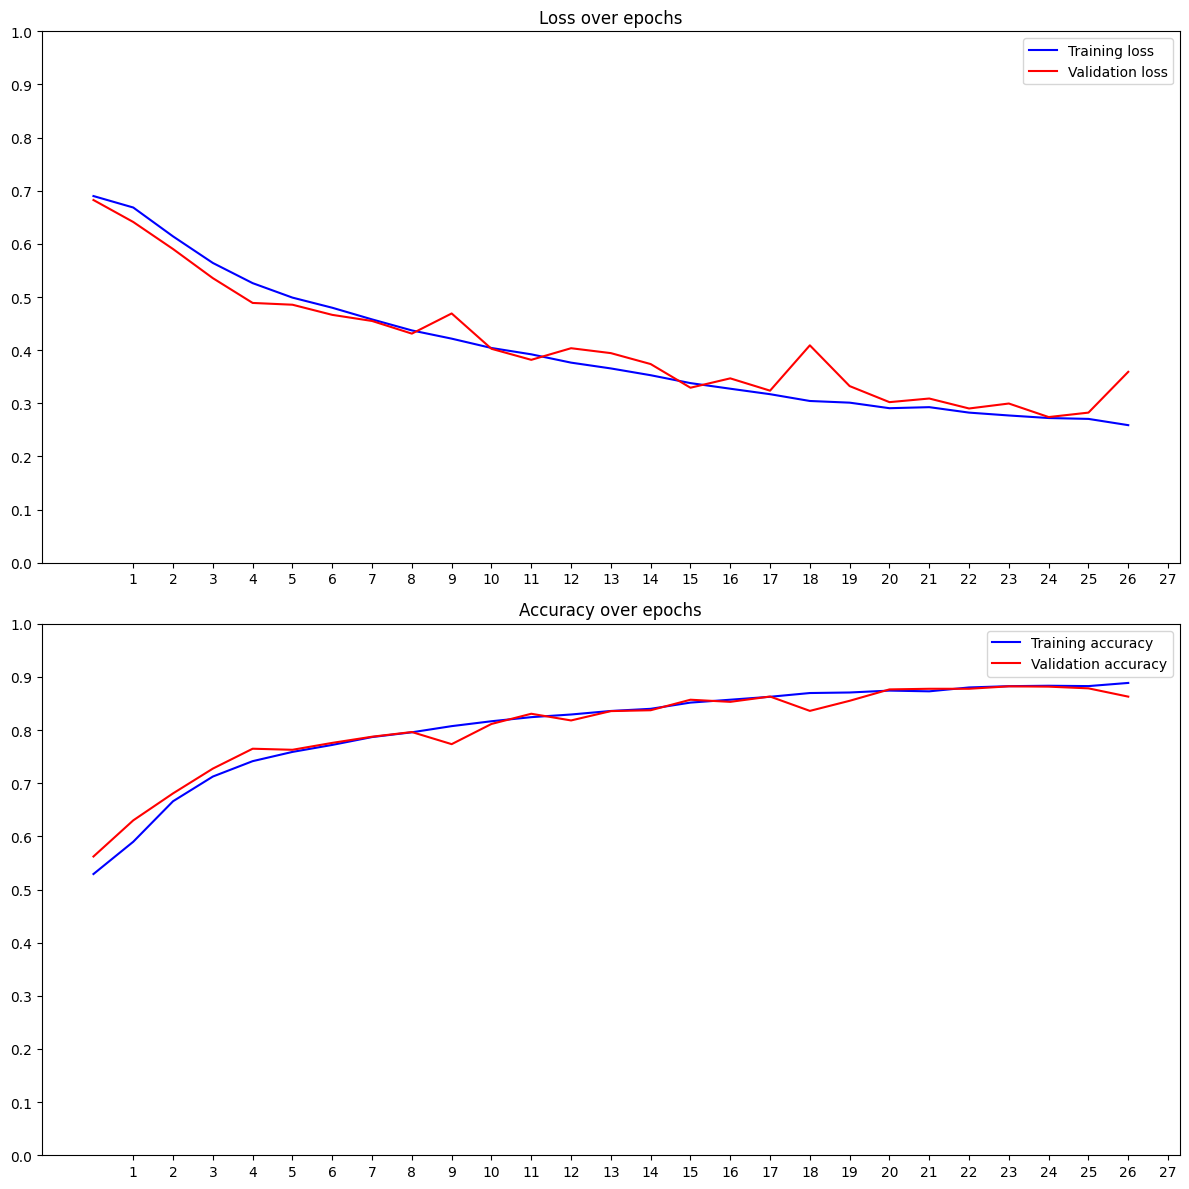

In [10]:
epochs = len(history.history['loss'])  # automatically get epoch count

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# --- Loss plot ---
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs + 1, 1))
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax1.set_title("Loss over epochs")
ax1.legend()

# --- Accuracy plot ---
ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs + 1, 1))
ax2.set_yticks(np.arange(0, 1.1, 0.1))
ax2.set_title("Accuracy over epochs")
ax2.legend()

plt.tight_layout()
plt.show()